In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd.functional import hessian
import math 

In [2]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.sigmoid(self.fc1(x))
        out = self.fc2(out)
        return out

In [3]:
#Preconditioned gradient by grad squared
class MyOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(MyOptimizer, self).__init__(params, defaults)
  
    def step(self, closure=None):
        """Performs a single optimization step.
        
        Args:
            closure (callable, optional): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('MyOptimizer does not support sparse gradients')
                
                # Simple approximation: second_derivative approximated by grad squared
                second_derivative = grad**2 + 1e-8  # added a small constant for numerical stability
                update = grad / second_derivative
                
                p.data = p.data - group['lr'] * update

        return loss

In [32]:
#Accelrated and Preconditioned gradient by finit element
class MyOptimizer2(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(MyOptimizer2, self).__init__(params, defaults)
  
    def step(self, closure=None):
        """Performs a single optimization step.
        
        Args:
            closure (callable, optional): A closure that reevaluates the model and returns the loss.
        """
        eps= 1e-8
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lrs=np.array(group['lr'])
            if np.size(lrs)==2: 
                lr1 = group['lr'][0]
                lr2 = group['lr'][1]
            else:
                lr1 = 0.1
                lr2 = eps
            for p in group['params']:
                if p.grad is None:
                    continue
                c_grad = p.grad.data
                if c_grad.is_sparse:
                    raise RuntimeError('MyOptimizer does not support sparse gradients')
                p.data = p.data+eps
                n_grad = p.grad.data
                p.data = p.data-eps
                # Finit element approximation
                second_derivative = ((n_grad-c_grad)/eps) + eps  # added a small constant for numerical stability
                update = c_grad / second_derivative
                
                p.data = p.data - lr1 * c_grad -lr2*update

        return loss

In [25]:
#Preconditioned gradient by finit element
class MyOptimizer3(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(MyOptimizer2, self).__init__(params, defaults)
  
    def step(self, closure=None):
        """Performs a single optimization step.
        
        Args:
            closure (callable, optional): A closure that reevaluates the model and returns the loss.
        """
        eps= 1e-8
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                c_grad = p.grad.data
                if c_grad.is_sparse:
                    raise RuntimeError('MyOptimizer does not support sparse gradients')
                p.data = p.data+eps
                n_grad = p.grad.data
                p.data = p.data-eps
                # Finit element approximation
                second_derivative = ((n_grad-c_grad)/eps) + eps  # added a small constant for numerical stability
                update = c_grad / second_derivative
                
                p.data = p.data - group['lr'] *update

        return loss

In [26]:
def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    return train_loader

In [27]:
def model_loss(output, labels, criterion):
    return criterion(output, labels)

In [28]:
def train_model(model, train_loader, optimizer, epochs, learning_rate, criterion):
    losses = []
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(-1, 28*28)  # Flatten MNIST images
            outputs = model(images)
            loss = criterion(outputs, labels)

            model.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())  # Collect loss for plotting
    return losses

In [22]:
def compare_optimizers():
    epochs = 5
    learning_rate = 0.01
    train_loader = load_mnist_data()
    input_size = 784
    hidden_size = 100
    num_classes = 10
    criterion = nn.CrossEntropyLoss()

    models = {
        'SGD': NN(input_size, hidden_size, num_classes),
        'Adam': NN(input_size, hidden_size, num_classes),
        'Nesterov': NN(input_size, hidden_size, num_classes),
        'Preconditioned': NN(input_size, hidden_size, num_classes)
    }

    optimizers = {
        'SGD': optim.SGD(models['SGD'].parameters(), lr=learning_rate),
        'Adam': optim.Adam(models['Adam'].parameters(), lr=learning_rate),
        'Nesterov': optim.SGD(models['Nesterov'].parameters(), lr=learning_rate, momentum=0.9, nesterov=True),
        'Preconditioned': MyOptimizer2(models['Preconditioned'].parameters(), lr=learning_rate)
        
    }

    results = {}
    for name, model in models.items():
        losses = train_model(model, train_loader, optimizers[name], epochs, learning_rate, criterion)
        results[name] = losses
    

    # Plotting all results
    plt.figure(figsize=(10, 5))
    for name, losses in results.items():
        plt.plot(losses, label=f'{name} Loss')

    plt.title('Comparison of Optimization Methods on MNIST')
    plt.xlabel('Number of Batches Processed')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



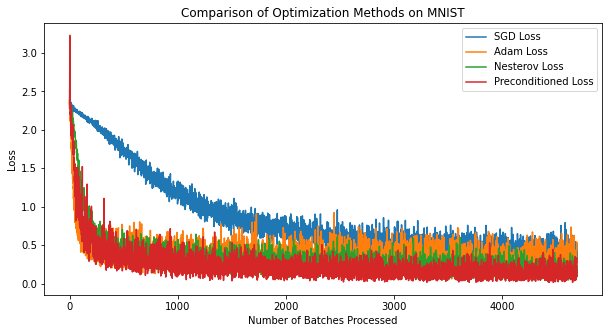

In [33]:
if __name__ == "__main__":
    compare_optimizers()